In [1]:
# initialize Spark Session
import os
import sys
top_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))
if top_dir not in sys.path:
    sys.path.append(top_dir)

from init_spark import init_spark
spark = init_spark()
spark

Initializing Spark...
Spark found in :  /home/ubuntu/apps/spark
Spark config:
	 spark.app.name=TestApp
	spark.master=local[*]
	executor.memory=2g
	spark.sql.warehouse.dir=/tmp/tmpby56jbet
	some_property=some_value
Spark UI running on port 4040


In [2]:
house_csv= spark.read.csv("/data/house-prices/house-sales-full.csv", header=True, inferSchema=True)
house_sales_simplified = spark.read.csv("/data/house-prices/house-sales-simplified.csv", header=True, inferSchema=True)
house_sales_sample = spark.read.csv("/data/house-prices/house-sales-sample.csv", header=True, inferSchema=True)

In [6]:
house_csv.write.parquet("house-parquet")

In [7]:
house_parquet= spark.read.parquet("./house-parquet")

In [8]:
house_parquet.show()

+----------+--------+---------+----------+-------------+-------+-------+-----------+------------+--------------+-------+-------------+---------------+---------+--------+---------+-------+-----------+------------+-------+-------+-------+---------------+
|DocumentID|    Date|SalePrice|PropertyID| PropertyType|     ym|zhvi_px|   zhvi_idx|AdjSalePrice|NbrLivingUnits|SqFtLot|SqFtTotLiving|SqFtFinBasement|Bathrooms|Bedrooms|BldgGrade|YrBuilt|YrRenovated|TrafficNoise|LandVal|ImpsVal|ZipCode|NewConstruction|
+----------+--------+---------+----------+-------------+-------+-------+-----------+------------+--------------+-------+-------------+---------------+---------+--------+---------+-------+-----------+------------+-------+-------+-------+---------------+
|         1| 9/16/14|   280000|   1000102|    Multiplex| 9/1/14| 405100|0.930836397|    300805.0|             2|   9373|         2400|              0|      3.0|       6|        7|   1991|          0|           0|  70000| 229000|  98002|     

In [9]:
house_parquet.groupBy("SalePrice").count().orderBy("count", ascending=False).show()

+---------+-----+
|SalePrice|count|
+---------+-----+
|   350000|  229|
|   400000|  192|
|   450000|  175|
|   425000|  169|
|   300000|  162|
|   375000|  162|
|   500000|  153|
|   320000|  151|
|   330000|  151|
|   390000|  151|
|   385000|  149|
|   380000|  147|
|   410000|  145|
|   525000|  145|
|   360000|  143|
|   310000|  142|
|   325000|  136|
|   340000|  135|
|   430000|  134|
|   435000|  133|
+---------+-----+
only showing top 20 rows



In [10]:
house_parquet.groupBy("PropertyType", "SalePrice").count().orderBy("count", ascending=False).show()

+-------------+---------+-----+
| PropertyType|SalePrice|count|
+-------------+---------+-----+
|Single Family|   350000|  193|
|Single Family|   400000|  163|
|Single Family|   450000|  148|
|Single Family|   425000|  145|
|Single Family|   300000|  142|
|Single Family|   375000|  136|
|Single Family|   500000|  133|
|Single Family|   525000|  133|
|Single Family|   310000|  126|
|Single Family|   330000|  125|
|Single Family|   390000|  125|
|Single Family|   380000|  124|
|Single Family|   320000|  124|
|Single Family|   410000|  119|
|Single Family|   550000|  117|
|Single Family|   360000|  116|
|Single Family|   420000|  114|
|Single Family|   430000|  113|
|Single Family|   340000|  112|
|Single Family|   385000|  112|
+-------------+---------+-----+
only showing top 20 rows



In [11]:
house_parquet.join(house_sales_simplified).join(house_sales_sample)

DataFrame[DocumentID: int, Date: string, SalePrice: int, PropertyID: bigint, PropertyType: string, ym: string, zhvi_px: int, zhvi_idx: double, AdjSalePrice: double, NbrLivingUnits: int, SqFtLot: int, SqFtTotLiving: int, SqFtFinBasement: int, Bathrooms: double, Bedrooms: int, BldgGrade: int, YrBuilt: int, YrRenovated: int, TrafficNoise: int, LandVal: int, ImpsVal: int, ZipCode: int, NewConstruction: boolean, ID: int, Date: string, SalePrice: int, PropertyID: bigint, PropertyType: string, Bedrooms: int, Bathrooms: double, SqFtTotLiving: int, SqFtLot: int, YrBuilt: int, ZipCode: int, ID: int, Date: string, SalePrice: int, PropertyID: bigint, PropertyType: string, Bedrooms: int, Bathrooms: double, SqFtTotLiving: int, SqFtLot: int, YrBuilt: int, ZipCode: int]

<AxesSubplot:>

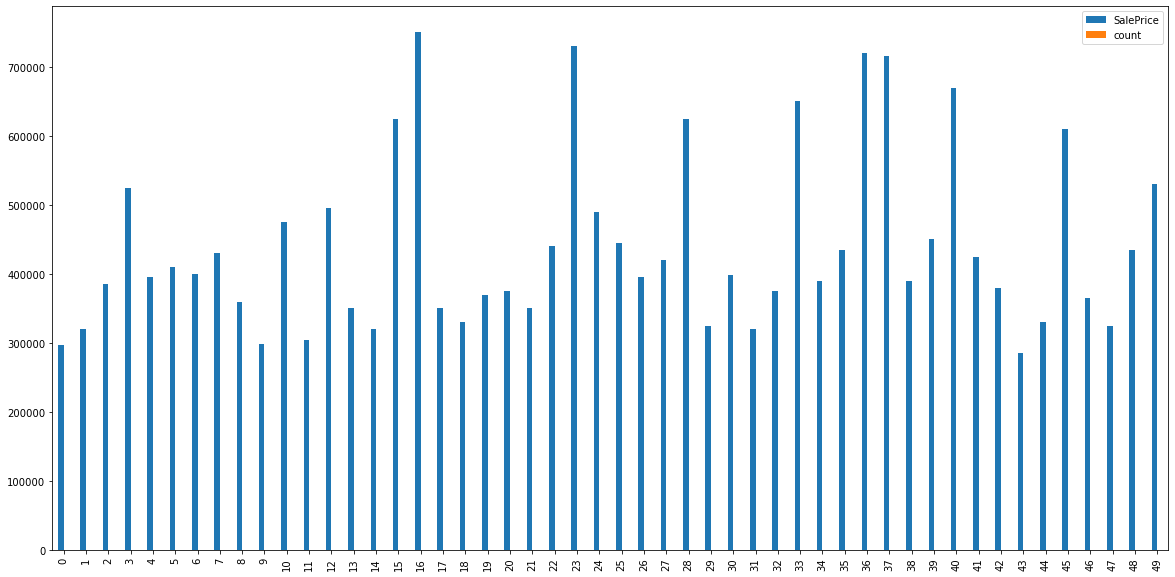

In [34]:
house_parquet.groupBy('SalePrice', 'Date').count().orderBy("count", ascending=False).limit(50).toPandas().plot.bar(figsize=(20,10))

+-----------------+
|Total Square Feet|
+-----------------+
|            11773|
|            25372|
|            28996|
|            13458|
|            10340|
|             1942|
|            36215|
|            17139|
|             6314|
|            12565|
|            13590|
|             7550|
|             6030|
|             6030|
|             3255|
|             9440|
|             2608|
|             7165|
|             2384|
|             7503|
+-----------------+
only showing top 20 rows

+--------+-------------+---------+--------------+
|    Date| PropertyType|Bathrooms|sum(SalePrice)|
+--------+-------------+---------+--------------+
|  6/8/06|Single Family|      2.5|       5308092|
| 8/23/12|Single Family|      2.5|        947000|
| 4/19/12|Single Family|      2.5|       1160500|
| 6/29/07|Single Family|      2.5|       2733000|
|  7/1/11|Single Family|      2.5|        635900|
| 11/7/06|Single Family|     1.75|       2219700|
|  5/8/09|Single Family|     1.75|       102

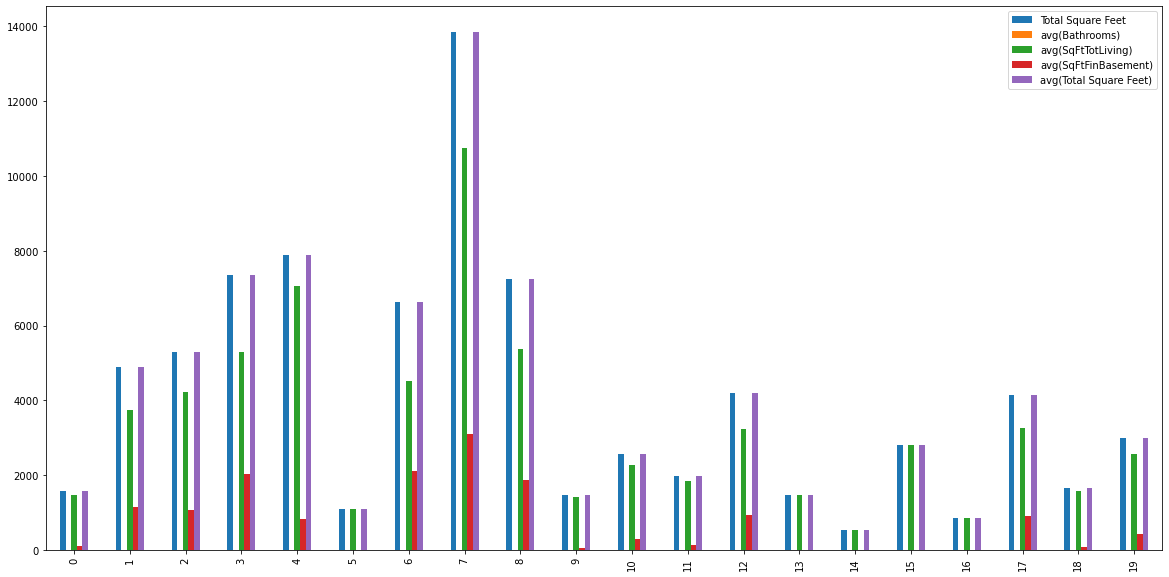

In [96]:
from pyspark.sql.functions import col

total_square_feet = house_parquet.select(((col("SqFtLot") + col("SqFtTotLiving") + col("SqFtFinBasement"))).alias("Total Square Feet"))
total_square_feet.show()

# calculate total square feet of houses and then average
total_sq_ft = house_parquet.withColumn("Total Square Feet", col("SqFtTotLiving") + col("SqFtFinBasement")).select(['Date', 'PropertyType', 'Bathrooms', 'SqFtTotLiving', 'SqFtFinBasement', "Total Square Feet"])
total_sq_ft.groupBy("Total Square Feet").avg().limit(20).toPandas().plot.bar(figsize=(20,10))

# group by the following
house_parquet.groupBy("Date", "PropertyType", "Bathrooms").sum("SalePrice").show()